# Formal Behavior Testing
Evaluating theory for dynamic consistency by formalizing statements about system behavior

*James Houghton*

In [1]:
%pylab inline
import pyDOE
import pandas as pd

Populating the interactive namespace from numpy and matplotlib


The process of formalizing theory as a simulation model helps to discipline a researcher's effort, forcing them to be explicit in their assumptions and logically consistent in their theory's structure. Similarly, the process of formalizing statements of system behavior with respect to time or as a result of varying parameters promotes rigor in claims of observable behavior of the system. The discipline of software testing has lessons for how such behavioral tests are constructed and provides a toolset for efficiently doing so. The approach has benefits for those seeking to create their own theories, and to understand theories promoted in existing literature.

## Structural Consistency
Are the statements of theory structure logically consistent with one another? Are they ambiguous, missing pieces, or conflicting?

The process of modeling can be used as a personal discipline, enforcing rigor in the understanding of a theory's structure.

- Make assumptions explicit
- Enforce exhaustive structural communication
- Identify system boundaries


"Formalization helps you to recognize vague concepts and resolve contradictions. 
Formalization is where the real test of your understanding occurs: computers accept no hand waving arguments."

*Business Dynamics. Sterman 2000, 3.5.3*

### Example of Formalizing Structural Statements

"The value of achieving success [in a protest] depends on whether things might be gained by action... this
includes both new advantages and avoiding harms that are currently experienced or anticipated" 

*Threat (and Opportunity): Popular Action and State Response in the Dynamics of Contentious Action. Goldstone and Tilly 2001*

**Interpretation:**

`Gains that would result from success = New Advantages + Harms Avoided`

![model diagram](Goldstone_Tilly_2001.png)

## Behavioral Consistency
Does the theory's structure actually **create the behavior** that is described by the theory's authors?

Two contexts:
- Testing preconstructed theories against their assumed implied behavior
- Testing dynamic models during construction for consistency with observed behavior

"I examine an existing theory in detail, formalizing it to investigate how well the theory 
accounts for the phenomena it's authors set out to explain."

 *Problems and paradoxes in a model of punctuated organizational change. Sastry 1997*

"The purpose of the model is... to play the roles of the actors in the system and to trace
out the consequences of their actions over time, thus providing a test of the theory 
by checking whether the assumptions can actually produce [asserted behavior]."

*The growth of knowledge: Testing a theory of scientific revolutions with a formal model. Sterman 1985*

### Lessons from software testing
We normally express statements of behavior as *'Reference Modes'*, and then manually compare reference modes to behavior. 

We can learn from explicit behavioral testing in software development: 

| Software Development                     | SD Modeling                                 | 
| ---------------------------------------- | ------------------------------------------- | 
| Make expected behavior of code explicit  | Make statements of system behavior explicit |
| Make developing software easier          | Help with model formulation                 |
| Ensure robustness to unknown user input  | Ensure robustness to uncertain parameters   | 
| Support code acceptance by client        | Create defensible statements of behavior    |



"Testing is an extremely creative and intellectually challenging
task." 

*The art of Software Testing - Myers et. al 2012*

## A Software Testing Example

In [2]:
def test_step(self):
    """ Tests the PySD version of Vensim's `STEP` function """
    from pysd import functions  # What are we examining?

    functions.time = lambda: 5  # What are the conditions of our test?
    self.assertEqual(functions.step(1, 10), 0) # what is expected?

    functions.time = lambda: 15  # New conditions
    self.assertEqual(functions.step(1, 10), 1)  # New expectation

    functions.time = lambda: 10
    self.assertEqual(functions.step(1, 10), 1)

### Example: Threat (and Opportunity): Popular Action and State Response in the Dynamics of Contentious Action

Goldstone and Tilly 2001
![Goldstone Tilly Coding](Goldstone_Tilly_2001_Coding.png)

In [3]:
import pysd
model = pysd.read_vensim("Goldstone_Tilly_2001.mdl")

In [4]:
p_ranges = {
    'Concession fractional adjustment':(1,2),
    'Repression fractional adjustment':(1,2),
    'Initial level of current threat':(0,5),
    'New advantages A':(0,5),
    'Threat rate':(0,2),
    'Concession rate':(0,2),
    'Probability of success O':(0,1),
    'Repression unit cost':(0,5),
    'Concession unit cost':(0,5)
}

# Latin Hypercube Sample of Parameter Space
norm_samples = pyDOE.lhs(n=len(p_ranges), samples=500)
parameters = pd.DataFrame([{key:n*(p[1]-p[0])+p[0] for n,(key,p) 
                            in zip(row, p_ranges.items())} 
                           for row in norm_samples])

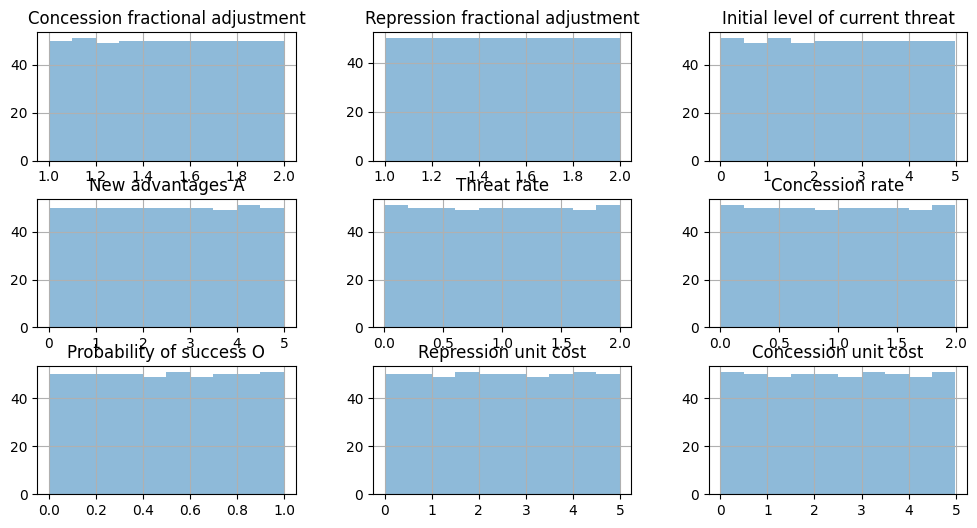

In [5]:
parameters.hist(figsize=(12,6), layout=(3,3), 
                histtype='stepfilled', alpha=.5);

## Behavior Over Time Tests
Within a single run of the model, assessing if the behavior of the simulation actually follows that which is described by the authors:

**Claim:** "[The State] may **swing back and forth** between concessions and repression, trying to find a combination that quells protest..." Pg. 188

**Interpretation:**
In some cases, the regime may begin by primarily working to increase either repression or concessions, such that the instantaneous rate of `Making concessions` is greater (or less) than that of `Making threats` and then at some point in the simulation, **the relative weighting of these two parameters will switch**.


In [6]:
def test(row):
    output = model.run(row.to_dict(), 
                       return_columns=['Making concessions','Making threats'])
    # is there a preference for making concessions at some point?
    repr_pref = output['Making concessions'] > output['Making threats']
    # is there a preference for making threats at some point?
    threat_pref = output['Making concessions'] < output['Making threats']
    # do both preferences occur at various points?
    return any(repr_pref) and any(threat_pref)

result = parameters.apply(test, axis=1)
print(any(result))

True


## Parametric Tests

- Testing comparisons of how the system would respond to various conditions. 
- Testing model behavior over a range of values for exogenous parameters.

**Claim:** Authoritarian states may ... rachet up repression **too slowly and insufficiently** to halt mobilization. Pg. 188

**Interpretation:** In some cases, slow implementation of repression may fail to stop protests that would have been successfully repressed through rapid application of the same absolute level of repression.

In [ ]:
def test(row):
    params = row.to_dict()
    repressive_threshold = np.NaN
    for threat_rate in np.linspace(*p_ranges['Threat rate'], num=10):  
        res = model.run(params.update({'Threat rate': threat_rate}),  
                        return_columns=['Protest', 
                                        'Repressive threat Tr']).iloc[0]
        if res['Protest'] == 0:  # protest is quelled
            if repressive_threshold is np.NaN:  # first successful
                repressive_threshold = res['Repressive threat Tr']
            elif (res['Repressive threat Tr'] < repressive_threshold - .0001): 
                return True  # higher rate succeeds over lower rate
    return False

result = parameters.apply(test, axis=1)
print(any(result))

## Conclusions
- The process of formalizing statements of system behavior with respect to time or as a result of varying parameters promotes rigor in claims of observable behavior of the system. 
- The field of software testing has lessons for how such behavioral tests are constructed and provides a toolset for efficiently doing so. 
- The approach has benefits for those seeking to create their own theories, and to understand theories promoted in existing literature.

### If behavioral claims *are* consistent with theory:

- Your claims are stated in a defensible way 

-or-

- You have mastery of an important theory in your field

Todo: Look for new observable implications of the theory.

### Behavioral claims *are not* consistent with theory:
- You found a problem with your model before anyone else did 

-or-
- You found a problem with an important theory in your field

Todo: Fix the holes.

"We must design assessment into our work from the start so we can discover errors more quickly" 

*All models are wrong: Reflections on becoming a systems scientist. Sterman 2002*

"Let every man test his own work. Then he will be proud of his own work." 

*Biblical Letter from Paul of Tarsus to the Galatians. c50 AD. ch.6 v.4*